In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj
from torch_geometric.transforms import NormalizeFeatures
from nn import GCNLayer, GCN

In [20]:
# create the adjaceny matrix from the edge index
def create_adj(edge_index, num_nodes):
    # edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    adj = np.zeros((num_nodes, num_nodes), dtype=int)
    for i, j in edge_index:
        adj[i-1, j-1] = 1
        adj[j-1, i-1] = 1
    
    adj = torch.tensor(adj, dtype=torch.float) + torch.eye(num_nodes)
    return adj

data = np.loadtxt("ucidata-zachary/out.ucidata-zachary", dtype=int, skiprows=2)

num_nodes = 34
adj = create_adj(data, num_nodes)
features = torch.eye(num_nodes)
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21]
labels = [0 if i in labels else 1 for i in range(num_nodes)]
labels = torch.tensor(labels, dtype=torch.long)


In [21]:
# model and optimizer
model = GCN(nin=features.shape[1], nout=16, nhid=16, nclass=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [11]:
test = torch.tensor([[0, 1], [2, 3]], dtype=torch.long)
test = torch.flatten(test)

test.shape

torch.Size([4])

In [18]:
# train the model
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    output = model(features, adj)           # n x 2
    loss = F.cross_entropy(output, labels)  # for each node, cross entropy loss compares the probability of the labels to the true label
    loss.backward()
    optimizer.step()

    print(f"Epoch: {epoch}, Loss: {loss.item()}")



Epoch: 0, Loss: 0.0003149326948914677
Epoch: 1, Loss: 0.00031200028024613857
Epoch: 2, Loss: 0.00030912712099961936
Epoch: 3, Loss: 0.00030627468368038535
Epoch: 4, Loss: 0.0003034606052096933
Epoch: 5, Loss: 0.0003006952756550163
Epoch: 6, Loss: 0.00029797526076436043
Epoch: 7, Loss: 0.0002952970680780709
Epoch: 8, Loss: 0.0002926501911133528
Epoch: 9, Loss: 0.0002900415565818548
Epoch: 10, Loss: 0.00028747128089889884
Epoch: 11, Loss: 0.0002849323209375143
Epoch: 12, Loss: 0.0002824422554112971
Epoch: 13, Loss: 0.00027996947756037116
Epoch: 14, Loss: 0.00027753852191381156
Epoch: 15, Loss: 0.0002751459542196244
Epoch: 16, Loss: 0.00027277422486804426
Epoch: 17, Loss: 0.00027045136084780097
Epoch: 18, Loss: 0.0002681528276298195
Epoch: 19, Loss: 0.0002658716693986207
Epoch: 20, Loss: 0.00026362185599282384
Epoch: 21, Loss: 0.00026140696718357503
Epoch: 22, Loss: 0.0002592304372228682
Epoch: 23, Loss: 0.00025707477470859885
Epoch: 24, Loss: 0.0002549505152273923
Epoch: 25, Loss: 0.0002

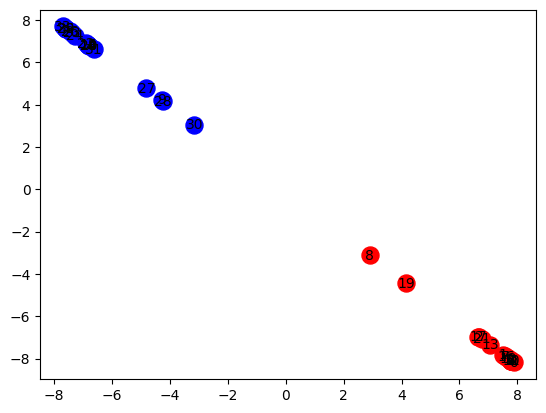

In [23]:
# plot the outputs on a 2D plane
plt.scatter(output[:, 0].detach().numpy(), output[:, 1].detach().numpy())

# if the ith node is labeled 0, color it red, else blue
for i in range(num_nodes):
    if labels[i] == 0:
        plt.scatter(output[i, 0].detach().numpy(), output[i, 1].detach().numpy(), color='red', s=150)
    else:
        plt.scatter(output[i, 0].detach().numpy(), output[i, 1].detach().numpy(), color='blue', s=150)

# label the nodes, centered
for i in range(num_nodes):
    plt.text(output[i, 0].detach().numpy(), output[i, 1].detach().numpy(), str(i), ha='center', va='center')

plt.show()